In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Classificação de texto

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

#Verifica os dados no diretorio

Data = os.listdir("../Filter/Tweets_Filtered/")
for i in range(len(Data)):
    Data[i] = Data[i].split(".")[0]
    
Pessoas = ["realDonaldTrump", "jairbolsonaro", "hbredda", "gui_benchimol", "pedrocerize"]

NoticiasPolitica = ["OGloboPolitica", "folha_poder", "GloboNews", "EstadaoPolitica", 
                    "RevistaEpoca", "valoreconomico", "g1politica", "conexaopolitica", "EstadaoEconomia", 
                    "UOLEconomia", "folha_mercado", "g1economia", "OGlobo_Economia"]

Noticias = ["UOL", "folha", "g1", "VEJA", "cartacapital", "RevistaISTOE"]

#Monta um dicionario com todos datasets de twites de todas as pessoas
Alvo = NoticiasPolitica


AllData = pd.DataFrame()
for i in Alvo:
    if i in Data:
        MoreData = pd.read_csv("../Filter/Tweets_Filtered/{0}".format(i+".csv"), sep=";", decimal=",", encoding='utf-16')
        AllData = pd.concat([AllData, MoreData])
    else:
        print("{0} não disponivel".format(i))
        
AllData = AllData.reset_index(drop=True)

In [3]:
X =  list(AllData["Texto"])

# Análise de tópicos

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

min_ocur=0.0005
Stop = ["istoégente", "expressoepoca", "globonews", "estudioi", "rt", "andreiasadi"]

vec = CountVectorizer(max_df=0.15, min_df=min_ocur, stop_words=Stop)
tf = vec.fit_transform(X)

In [5]:
tf_feature_names = vec.get_feature_names()
len(tf_feature_names)

2912

In [6]:
from sklearn.decomposition import LatentDirichletAllocation

n_components = 30

lda = LatentDirichletAllocation(
    n_components=n_components, max_iter=5, 
    learning_method='online', learning_offset=50., 
    n_jobs=-1, verbose=1)

lda.fit(tf)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=30, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [7]:
import pickle

# Store data (serialize)
with open('./Models/lda_fited_30.pickle', 'wb') as handle:
    pickle.dump(lda, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./Models/cv_fited.pickle', 'wb') as handle:
    pickle.dump(vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Carrega o modelo se aplicavel

In [8]:
import pickle

# Store data (serialize)
with open('./Models/lda_fited_30.pickle', 'rb') as handle:
    lda = pickle.load(handle)
    
with open('./Models/cv_fited.pickle', 'rb') as handle:
    vec = pickle.load(handle)

## Filtra as ações

In [9]:
Stocks = ["ibov", "ITUB4", "PETR4", "Vale3", "BBDC4", "ABEV3", "BBAS3", "SANB3", "LREN3"]

Cols = {}
for i in range(len(Stocks)):
    Cols[Stocks[i]] = [i*4+i, i*4+i+1, i*4+i+2, i*4+i+3]

In [10]:
Var = 'PETR4'
bolsa = pd.read_excel('../Dados_Bolsa/Twt.xlsx', sheet_name="1h", usecols=Cols[Var],  skiprow=[0])

In [11]:
headers = list(bolsa.keys())
myheaders = [Var, "Price", "Volume", "Ticks"]

for i in range(len(headers)):
    bolsa.rename(columns={headers[i]: myheaders[i]}, inplace=True)
    
bolsa = bolsa.dropna()
bolsa.drop(bolsa.head(1).index,inplace=True)

bolsa = bolsa.reset_index(drop=True)

In [12]:
bolsa.head(5)

,PETR4,Price,Volume,Ticks
0,2018-10-09 10:00:00,26.53,16993100,16015
1,2018-10-09 11:00:00,26.69,17752300,13529
2,2018-10-09 12:00:00,26.79,7840900,9768
3,2018-10-09 13:00:00,26.83,8244300,9649
4,2018-10-09 14:00:00,26.84,7674700,8604


In [13]:
ibov_len  = len(bolsa[Var])
ibov_len

1099

In [14]:
import datetime

ibov_data_precos = {}
DeadZoneUp = 0.3e-2
DeadZoneDown = 0.6e-2
# célula para identificar os preços de abertura e fechamento de cada dia
for i in range(0, ibov_len):
    data_completa = datetime.datetime.strptime(str(bolsa[Var][i]), '%Y-%m-%d %H:%M:%S')
    preco = bolsa['Price'][i]
    data = data_completa.strftime("%Y-%m-%d")
    if data not in ibov_data_precos:
        ibov_data_precos[data] = {}
        ibov_data_precos[data]['abertura'] = preco
        #caso só tenhamos informação de uma hora dentro de um dia, assumimos esse preco como o de fechamento tbm
        ibov_data_precos[data]['fechamento'] = preco 
        dia_anterior_completo =  data_completa - datetime.timedelta(days=1)
        dia_anterior_data = dia_anterior_completo.strftime("%Y-%m-%d")
        
        if(dia_anterior_data in ibov_data_precos):
            dia_anterior_fechamento = ibov_data_precos[dia_anterior_data]['fechamento']
            
            if(preco > dia_anterior_fechamento + dia_anterior_fechamento*DeadZoneUp):
                ibov_data_precos[data]['variacao'] = 2 #Subiu
            elif (preco < dia_anterior_fechamento - dia_anterior_fechamento*DeadZoneDown):
                ibov_data_precos[data]['variacao'] = 0 #Desceu
            else:
                ibov_data_precos[data]['variacao'] = 1
        else:
            #se não tivermos informações sobre o dia anterior, assumimos que a variacao foi neutra
            ibov_data_precos[data]['variacao'] = 0 
    else:
        if i < (ibov_len - 1):
            data_seguinte = datetime.datetime.strptime(str(bolsa[Var][i+1]), '%Y-%m-%d %H:%M:%S')
            if data_seguinte.date() > data_completa.date():
                ibov_data_precos[data]['fechamento'] = preco

Datesibov = list(ibov_data_precos.keys())
                
for i in range(4):
    print(Datesibov[i], ibov_data_precos[Datesibov[i]])

2018-10-09 {'abertura': 26.53, 'fechamento': 26.82, 'variacao': 0}
2018-10-10 {'abertura': 25.87, 'fechamento': 26.05, 'variacao': 0}
2018-10-11 {'abertura': 26.35, 'fechamento': 25.29, 'variacao': 2}
2018-10-15 {'abertura': 25.68, 'fechamento': 25.77, 'variacao': 0}


## Cria os Datasets

In [15]:
OutputData = []
TextData = []
for i in range(len(AllData)):
    data_completa = datetime.datetime.strptime(str(AllData["Data"][i]), '%Y-%m-%d %H:%M:%S')
    data = data_completa.strftime("%Y-%m-%d")
    if data in list(ibov_data_precos.keys()):
        OutputData.append(ibov_data_precos[data]["variacao"])
        TextData.append(AllData["Texto"].iloc[i])

In [16]:
len(OutputData), len(TextData)

(29223, 29223)

In [17]:
#Para criar sem covariancia e 5 dias (std scaler)
model = lda

tweet_counterized = vec.transform(TextData)
InputData = model.transform(tweet_counterized)

In [18]:
print(len(InputData[0]), len(InputData))

30 29223


In [19]:
print(InputData[1])

[0.0030303  0.0030303  0.0030303  0.0030303  0.0030303  0.0030303
 0.0030303  0.0030303  0.0030303  0.0030303  0.0030303  0.0030303
 0.0030303  0.91212121 0.0030303  0.0030303  0.0030303  0.0030303
 0.0030303  0.0030303  0.0030303  0.0030303  0.0030303  0.0030303
 0.0030303  0.0030303  0.0030303  0.0030303  0.0030303  0.0030303 ]


In [20]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_classes, test_classes = train_test_split(InputData, OutputData, 
                                                                        test_size=0.2, stratify=OutputData)

## Distribuição das Classes:

In [21]:
trainlen = len(train_classes)
testlen = len(test_classes)

print("Treinamento:")
print(train_classes.count(0)/trainlen)
print(train_classes.count(1)/trainlen)
print(train_classes.count(2)/trainlen)
print()
print("Teste:")
print(test_classes.count(0)/testlen)
print(test_classes.count(1)/testlen)
print(test_classes.count(2)/testlen)

Treinamento:
0.38008
0.28916
0.33076

Teste:
0.3357802510063936
0.33530665403741416
0.32891309495619225


## Aplicação de Modelos

In [22]:
from sklearn.model_selection import cross_val_predict, cross_val_score

### Regressão Logistica

In [23]:
from sklearn.linear_model import LogisticRegression

Losgisticclf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

scores = cross_val_score(Losgisticclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.36891809 0.37162509 0.36293634]
0.36782650714363113


### Decision Tree

In [24]:
from sklearn import tree

tree = tree.DecisionTreeClassifier()

scores = cross_val_score(tree, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.33566003 0.54439996 0.55041068]
0.47682355509868524


### Randon Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

RandonForestclf = RandomForestClassifier(n_estimators=10, n_jobs=-1)

scores = cross_val_score(RandonForestclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.34335865 0.54840365 0.54917864]
0.4803136508911306


In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10, 30, 100], 
    'min_impurity_decrease': [1e-3, 1e-4, 1e-5, 1e-6, 0]}
  ]

RandonForestclf = RandomForestClassifier(n_estimators=10, min_impurity_decrease=1e-3)

grid_search = GridSearchCV(RandonForestclf, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

grid_search.fit(InputData, OutputData)

print(grid_search.best_params_, grid_search.best_score_)

BestParams = grid_search.best_params_

RandonForestclf = RandomForestClassifier(n_estimators=BestParams["n_estimators"], 
                                         min_impurity_decrease=BestParams["min_impurity_decrease"])

{'min_impurity_decrease': 0, 'n_estimators': 100} 0.49642404955001196


### SVM

In [29]:
from sklearn.svm import SVC

SVMclf = SVC(gamma="scale", tol=1e-3, probability=True)

scores = cross_val_score(SVMclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.35978239 0.40385997 0.40338809]
0.38901014973496223


### Voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

VotingHard = VotingClassifier(estimators=[('LR', Losgisticclf), ('SVM', SVMclf), ('RF', RandonForestclf)],
                              voting='hard', n_jobs=-1)

scores = cross_val_score(VotingHard, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

## Best Model

In [29]:
TopClassifier = RandonForestclf

y_pred = cross_val_predict(TopClassifier, InputData, OutputData, cv=3)

In [34]:
Output_Pred = list(y_pred)

print("Resultado Modelo:")
print(Output_Pred.count(0)/len(Output_Pred))
print(Output_Pred.count(1)/len(Output_Pred))
print(Output_Pred.count(2)/len(Output_Pred))

Resultado Modelo:
0.4646682407692571
0.2293056838791363
0.3060260753516066


In [30]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(OutputData, Output_Pred)
conf_mx

array([[6608, 1750, 2562],
       [3208, 3458, 1979],
       [3763, 1493, 4402]], dtype=int64)

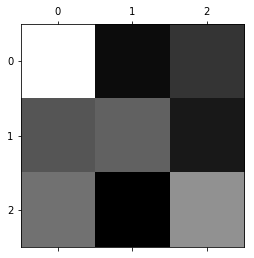

In [31]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [39]:
InputDataa = np.array(InputData)
OutputDataa = np.array(OutputData)
Output_Preda = np.array(Output_Pred)

In [50]:
AllResults = pd.DataFrame(InputData)
AllResults["Output"]= OutputDataa
AllResults["Output_pred"]= Output_Preda

AllResults.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,Output,Output_pred
23906,0.004167,0.130678,0.004167,0.004167,0.004167,0.129167,0.133490,0.004167,0.004167,0.004167,...,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.355101,0.004167,0,0
19252,0.003704,0.003704,0.003704,0.114815,0.003704,0.003704,0.003704,0.003704,0.225926,0.003704,...,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,2,0
7880,0.116834,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,...,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,2,1
25326,0.002778,0.002778,0.002778,0.002778,0.002778,0.086111,0.002778,0.002778,0.002778,0.086111,...,0.002778,0.002778,0.002778,0.086111,0.002778,0.169444,0.086111,0.086111,0,0
12665,0.172222,0.005556,0.005556,0.321891,0.005556,0.005556,0.172222,0.005556,0.005556,0.005556,...,0.005556,0.005556,0.189220,0.005556,0.005556,0.005556,0.005556,0.005556,2,2


In [64]:
ResultCorr = np.array(AllResults.corr())
AllResults.corr()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,Output,Output_pred
0,1.000000,-0.030097,-0.024330,-0.060380,-0.027685,-0.009441,-0.012241,-0.005701,-0.061106,-0.057670,...,-0.027933,-0.031507,-0.036953,-0.020579,-0.049948,-0.054528,-0.029616,-0.036280,0.011813,0.035119
1,-0.030097,1.000000,-0.020258,-0.051865,-0.018162,-0.015937,-0.023387,-0.014282,-0.030352,-0.036424,...,-0.020637,-0.032864,-0.013276,-0.034021,-0.023004,-0.015709,-0.010326,-0.026957,0.000485,-0.003690
2,-0.024330,-0.020258,1.000000,-0.029908,-0.030425,-0.006509,-0.023078,0.000434,-0.025784,-0.025452,...,-0.006929,-0.033296,-0.005128,-0.031891,-0.033924,-0.017210,-0.035574,-0.027613,-0.004143,-0.003375
3,-0.060380,-0.051865,-0.029908,1.000000,-0.082145,-0.075287,-0.046853,-0.044324,-0.041391,-0.051790,...,-0.054493,-0.060241,0.005932,-0.052687,-0.088277,-0.086297,-0.073849,-0.079363,0.004769,0.012233
4,-0.027685,-0.018162,-0.030425,-0.082145,1.000000,-0.011498,0.004024,-0.009922,-0.030118,-0.033364,...,-0.017332,-0.020582,-0.035658,-0.026910,-0.009286,-0.019933,-0.014092,-0.004967,-0.008373,-0.021251
5,-0.009441,-0.015937,-0.006509,-0.075287,-0.011498,1.000000,0.002365,-0.008806,-0.031688,-0.023984,...,-0.004127,-0.039472,-0.043805,-0.030417,-0.024971,-0.000312,-0.015792,-0.026975,0.007693,0.014992
6,-0.012241,-0.023387,-0.023078,-0.046853,0.004024,0.002365,1.000000,-0.017060,-0.034420,-0.017117,...,-0.018034,-0.018945,-0.035429,-0.017179,-0.031009,-0.034788,-0.009301,-0.035412,0.008034,0.023316
7,-0.005701,-0.014282,0.000434,-0.044324,-0.009922,-0.008806,-0.017060,1.000000,-0.023110,-0.015486,...,-0.014592,-0.028070,-0.034659,0.000089,-0.032025,-0.028647,0.011661,-0.027783,-0.009570,-0.006982
8,-0.061106,-0.030352,-0.025784,-0.041391,-0.030118,-0.031688,-0.034420,-0.023110,1.000000,-0.029017,...,-0.016630,-0.021378,-0.045980,-0.029280,-0.052168,-0.057264,-0.051536,-0.024880,-0.013285,-0.026858
9,-0.057670,-0.036424,-0.025452,-0.051790,-0.033364,-0.023984,-0.017117,-0.015486,-0.029017,1.000000,...,-0.029025,-0.051663,-0.042146,-0.040511,-0.043494,-0.044314,-0.075623,-0.059577,0.002125,0.005391


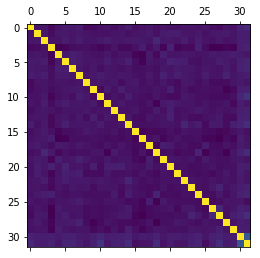

In [68]:
plt.matshow(ResultCorr)
plt.show()

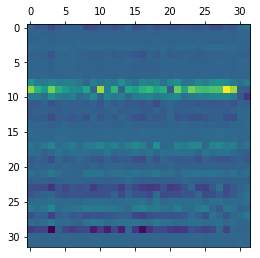

In [67]:
row_sums = ResultCorr.sum(axis=1, keepdims=True)
norm_corr = ResultCorr / row_sums
np.fill_diagonal(norm_corr, 0.005)

plt.matshow(norm_corr)
plt.show()